In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import PIL as pl
from PIL import Image, ImageFilter
import ezdxf
from scipy.interpolate import interp1d
import glob
import pickle


In [20]:
################ FIND CHESSBOARD CORNERS - OBJECT POINTS AND IMAGE POINTS #############################

chessboardSize = (14,10)#(13,9)
frameSize = (5184,3455)#(640,480)



# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((chessboardSize[0] * chessboardSize[1], 3), np.float32)
objp[:,:2] = np.mgrid[0:chessboardSize[0],0:chessboardSize[1]].T.reshape(-1,2)

size_of_chessboard_squares_mm = 19
objp = objp * size_of_chessboard_squares_mm


# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.


images = glob.glob('../data/png_19/*.png')

for image in images:

    img = cv2.imread(image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, chessboardSize, None)

    # If found, add object points, image points (after refining them)
    if ret == True:

        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, chessboardSize, corners2, ret)
        cv2.imshow('img', img)
        cv2.waitKey(1000)


cv2.destroyAllWindows()


############## CALIBRATION #######################################################

ret, cameraMatrix, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, frameSize, None, None)

print("camera calibration: ", ret)
print("\ncamera matrix: \n", cameraMatrix)
print("\ndistortion parametrs: \n", dist)
print("\nrotation vectors: \n", rvecs)
print("\ntranslation vector: \n", tvecs)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
pickle.dump((cameraMatrix, dist), open( "calibration.pkl", "wb" ))
pickle.dump(cameraMatrix, open( "cameraMatrix.pkl", "wb" ))
pickle.dump(dist, open( "dist.pkl", "wb" ))


############## UNDISTORTION #####################################################

img = cv2.imread('../data/img_for_calibration/test2.png')
h,  w = img.shape[:2]
newCameraMatrix, roi = cv2.getOptimalNewCameraMatrix(cameraMatrix, dist, (w,h), 1, (w,h))


# Undistort
dst = cv2.undistort(img, cameraMatrix, dist, None, newCameraMatrix)

# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
cv2.imwrite('../data/img_for_calibration/test2_calib_v1.png', dst)


# Undistort with Remapping
mapx, mapy = cv2.initUndistortRectifyMap(cameraMatrix, dist, None, newCameraMatrix, (w,h), 5)
dst = cv2.remap(img, mapx, mapy, cv2.INTER_LINEAR)

# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
cv2.imwrite('../data/img_for_calibration/test2_calib_v2.png', dst)


# Reprojection Error
mean_error = 0

for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], cameraMatrix, dist)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error

print( "total error: {}".format(mean_error/len(objpoints)) )


camera calibration:  0.8110897472082846

camera matrix: 
 [[1.36812029e+04 0.00000000e+00 2.66351290e+03]
 [0.00000000e+00 9.71941261e+03 1.60272117e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

distortion parametrs: 
 [[ 3.58620205e+00 -4.77633812e+01  6.69321996e-02  1.35928716e-01
   2.94972915e+02]]

rotation vectors: 
 (array([[0.12105393],
       [0.61213878],
       [0.17203273]]), array([[0.12113396],
       [0.61137013],
       [0.17198953]]), array([[ 0.013991  ],
       [-0.94837848],
       [ 0.04620363]]), array([[ 0.02108719],
       [ 0.65462166],
       [-0.13354124]]), array([[0.50282993],
       [0.43925994],
       [1.49432323]]), array([[ 0.50193197],
       [-0.82082605],
       [-0.80424958]]), array([[-0.22240681],
       [ 0.65803592],
       [-0.76801777]]), array([[ 0.36223264],
       [-0.80477383],
       [-0.83985413]]), array([[-0.07305941],
       [ 0.63673332],
       [-0.36182977]]), array([[0.09016669],
       [0.60592054],
       [0.0693227 ]

In [21]:
#calculating calibration matrix
import numpy as np
def rot_x(angle):
    cosa = np.cos(angle)
    sina = np.sin(angle)
    return np.array([[1, 0, 0], [0, cosa, -sina], [0, sina, cosa]])

def rot_y(angle):
    cosa = np.cos(angle)
    sina = np.sin(angle)
    return np.array([[cosa, 0, sina], [0, 1, 0], [-sina, 0, cosa]])

def rot_z(angle):
    cosa = np.cos(angle)
    sina = np.sin(angle)
    return np.array([[cosa, -sina, 0], [sina, cosa, 0], [0, 0, 1]])

rot_x_1 = rot_x(0)
rot_y_1 = rot_y(0)
rot_z_1 = rot_z(0)

rot_1 = rot_x_1 * rot_y_1 * rot_z_1

trans_1 = np.array([[212], [0], [0]])

I3 = np.array([[1, 0, 0],
               [0, 1, 0],
               [0, 0, 1]])

K1 = np.array([[1.36812029e+04, 0.00000000e+00, 2.66351290e+03],
 [0.00000000e+00, 9.71941261e+03, 1.60272117e+03],
 [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
     

P1 = np.dot(K1, np.dot(rot_1, np.hstack((I3, trans_1))))
cameraMatrix = P1
dist = [[ 3.58620205e+00, -4.77633812e+01,  6.69321996e-02,  1.35928716e-01,2.94972915e+02]]#[[-0.17793447, 0.22376621, 0.00098179, 0.00145806, -0.08411422]]

# [[1.36812029e+04 0.00000000e+00 2.66351290e+03]
#  [0.00000000e+00 9.71941261e+03 1.60272117e+03]
#  [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
# [[ 3.58620205e+00 -4.77633812e+01  6.69321996e-02  1.35928716e-01
#    2.94972915e+02]]

In [22]:
# # Uploda an image and undistorts it

# # Load the image
# img = cv2.imread("../data/test1.png")

# # Optimize camera matrix
# h,  w = img.shape[:2]
# newCameraMatrix, roi = cv2.getOptimalNewCameraMatrix(cameraMatrix, dist, (w,h), 1, (w,h))

# # Undistort
# dst = cv2.undistort(img, cameraMatrix, dist, None, newCameraMatrix)

# # crop the image
# x, y, w, h = roi
# dst = dst[y:y+h, x:x+w]
# cv2.imwrite('caliResult1.png', dst)


(1874, 1177, 3)


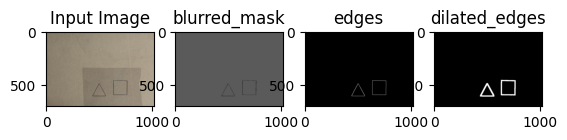

In [23]:
"""
# For collored lines only (green)
# Convert img to HSV
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Define the range of green color in HSV
lower_green = np.array([40, 50, 50])
upper_green = np.array([90, 255, 255])

# Threshold the HSV image to get only green colors
mask = cv2.inRange(hsv, lower_green, upper_green)"""

# Images uploaded to program
#img = cv2.imread("../data/line_detection_test_calib.png")
# Calibrated images directly from camera calibration
#img = cv2.imread("C:/Users/janpe/Desktop/Projekti/line_scann/camera_calibration/img_for_calibration/test2_calib_v2.png")
img = cv2.imread("../data/img_for_calibration/test2_calib_v2.png")

# Img crop
print(img.shape)
img = img[500:1200, 100:1119] #[top_row:bottom_row,top_columns:bottom_columns]
# My images have size (1884, 1219, 3)
 
scale_percent = 100 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
  
# Resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

# Img to grayscale
gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)

# Threshold the image to get only the black lines
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

(thresh, blackAndWhiteImage) = cv2.threshold(gray, 50, 90, cv2.THRESH_BINARY)

blurred_mask = cv2.GaussianBlur(blackAndWhiteImage,  (3, 3), sigmaX=3)#zamenjaj thresh za mask ce zelis barvne crte
# plt.subplot(121), plt.imshow(blackAndWhiteImage)
# plt.subplot(122), plt.imshow(blurred_mask)


# Canny edge detections
edges = cv2.Canny(blurred_mask, 10, 200)

# Kernel for morphological operations
kernel = np.ones((9,9), np.uint8)

# Dilate the edges
dilated_edges = cv2.dilate(edges, kernel, iterations=1)


# Erode the edges
# eroded_edges = cv2.erode(dilated_edges, kernel, iterations=1)
# erode_edges = cv2.erode(eroded_edges, kernel, iterations=1)

# Display the input and output images
plt.subplot(141), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Input Image')
plt.subplot(142), plt.imshow(cv2.cvtColor(blurred_mask, cv2.COLOR_GRAY2RGB)), plt.title('blurred_mask')
plt.subplot(143), plt.imshow(cv2.cvtColor(edges, cv2.COLOR_BGR2RGB)), plt.title('edges')
plt.subplot(144), plt.imshow(cv2.cvtColor(dilated_edges, cv2.COLOR_BGR2RGB)), plt.title('dilated_edges')
plt.show()

# Display the result
cv2.imwrite("..\data\edge_detection.png", dilated_edges)
cv2. destroyAllWindows()


In [24]:
# Scale dxf to apropriat size
def scale_png(png_file, scale_factor):
    # Load the PNG image
    image = cv2.imread(png_file)

    # Img dimensons
    height, width, _ = image.shape

    # Compute the new dimensions after scaling
    new_width = int(width * scale_factor_x)
    new_height = int(height * scale_factor_y)

    # Resize
    resized_image = cv2.resize(image, (new_width, new_height))

    scaled_png_file = png_file.replace(".png", "_scaled.png")
    cv2.imwrite(scaled_png_file, resized_image)

    return scaled_png_file

png_file = "..\\data\\edge_detection.png"
scale_factor_y = 0.701754386  # Scaling factor of 0.5 (50% reduction)
scale_factor_x = 0.717
scaled_png_file = scale_png(png_file, scale_factor_y)

In [25]:
# Convert .png to dxf

image = cv2.imread("..\data\edge_detection_scaled.png", cv2.IMREAD_GRAYSCALE)

# Grayscale
_, thresholded = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

# Finds contures
contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# DXF risba in dodaj sloj za konture
doc = ezdxf.new(dxfversion='R2010')
msp = doc.modelspace()

# draw contures
for contour in contours:
    points = np.squeeze(contour)
    msp.add_lwpolyline(points, format='xyseb')

doc.saveas("..\\data\\rezultat_calib.dxf")

In [26]:
# Conect all non connected lines
def close_lines(dxf_file):
    doc = ezdxf.readfile(dxf_file)
    msp = doc.modelspace()

    for entity in msp:
        if entity.dxftype() == 'LWPOLYLINE' and not entity.closed:
            points = entity.get_points()

            # Check if the start and end points are different
            start = points[0]
            end = points[-1]
            if start != end:
                # Add the start point to the end of the points list
                points.append(start)
                # Update the points of the polyline
                entity.set_points(points)
                # Close the polyline
                entity.closed = True

    doc.saveas(dxf_file)

dxf_file = "..\\data\\rezultat_connected.dxf"
close_lines(dxf_file)
